## Convolutional Neural Network

references: 
- [https://wegonnamakeit.tistory.com/48](https://wegonnamakeit.tistory.com/48)
- [http://taewan.kim/post/cnn/](http://taewan.kim/post/cnn/)
- [https://cheong.netlify.app/machine-learning/2019-10-14---cs231n-cnn-architectures/](https://cheong.netlify.app/machine-learning/2019-10-14---cs231n-cnn-architectures/)
- [https://kjhov195.github.io/2020-01-07-activation_function_2/](https://kjhov195.github.io/2020-01-07-activation_function_2/)
- [https://jsideas.net/batch_normalization/](https://jsideas.net/batch_normalization/)

### Basic CNN
CNN을 구성할때 보편적으로 사용되는 layers에 대해서 알아보겠습니다. <br/>



#### Convolution layer (or spatial convolution layer)

![img](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif)

- Convolution: 이미지 위에 stride 값 만큼 filter(or kernel)을 이동시키면서 겹쳐지는 부분의 각 원소의 값을 모두 곱한 뒤 합산한 값을 출력하는 연산
- filter(or kernel): number_of_filters x input_channels x kernel_size x kernel_size
- Stride: filter를 sliding window 방식으로 한 번에 이동시키는 간격
- Padding: pad 크기 만큼 이미지의 상하좌우에 '0'으로 값을 채우는 것. output의 width, height 크기를 조절하기 위해 사용합니다. 
- input(image or features): Batch x Channel x Height x Width (Pytorch: BCHW format, Tensorflow: BHWC format)
  - Batch는 입력데이터의 묶음을 의미합니다. 입력데이터를 이미지 한 장으로 구성한다면 1 x C x H x W와 같습니다. 이미지의 크기가 256 x 256이고, RGB channel이라면 입력데이터는 1x3x256x256 입니다.
- output(features or feature map): Batch x number_of_filters x computed_height x computed_width
  - computed_width = ((width - kernel_size + 2*pad) / stride) + 1
  - computed_height = ((height - kernel_size + 2*pad) / stride) + 1


In [1]:
import torch
import torch.nn as nn

in_channels = 3
out_channels = 2 # out_channels은 number_of_filters과 동일하다.
kernel_size = 3
stride = 2
pad = 1

# Basic 2D convolution layer
conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=pad)

print('conv.weight:\n', conv.weight) 
print('conv.weight.shape:\n', conv.weight.shape) # filter(kernel) size는 곧 weights size와 동일합니다.
print()
print('conv.bias:\n', conv.bias)
print('conv.bias.shape:\n', conv.bias.shape) # Convolution layer도 linear layer와 마찬가지로 bias를 가질 수 있습니다.
print()

inp = torch.ones((1, 3, 256, 256)) # 256x256x3
print('input:\n', inp)

out = conv(inp)
print('output:\n', out)
print('output.shape:\n', out.shape)


conv.weight:
 Parameter containing:
tensor([[[[-0.1714, -0.1633,  0.0155],
          [ 0.0130,  0.0025, -0.0413],
          [-0.1491, -0.0082, -0.1326]],

         [[ 0.0055,  0.1410, -0.1737],
          [ 0.0885, -0.0911, -0.1266],
          [-0.0893, -0.0882,  0.1075]],

         [[ 0.0076,  0.1829,  0.0499],
          [-0.0746, -0.0210, -0.1447],
          [-0.0191, -0.0113, -0.1284]]],


        [[[-0.1407, -0.0149, -0.0173],
          [-0.0711,  0.0406, -0.1440],
          [-0.1912,  0.1816,  0.1623]],

         [[ 0.0691,  0.1679, -0.0347],
          [ 0.1207,  0.0355,  0.1410],
          [ 0.1236, -0.0073,  0.1920]],

         [[ 0.1074,  0.1647,  0.1904],
          [ 0.0600, -0.1610,  0.0631],
          [ 0.1410,  0.1800, -0.1080]]]], requires_grad=True)
conv.weight.shape:
 torch.Size([2, 3, 3, 3])

conv.bias:
 Parameter containing:
tensor([-0.1840,  0.1339], requires_grad=True)
conv.bias.shape:
 torch.Size([2])

input:
 tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 

#### Max Pooling layer

<img src="https://www.jeremyjordan.me/content/images/2017/07/Screen-Shot-2017-07-27-at-11.43.19-AM.png" width="600">

- pooling_size(kernel_size): pooling layer에서 사용되는 sliding window size.
- stride: sliding window가 이동하는 간격 (보통 pooling size와 동일하게 설정함)
- input: Batch x Channel x Height x Width
- output: Batch x Channel x computed_height x computed_width (Channel은 유지함)
- computed_height = Height / pooling_size
- computed_width = Width / pooling_size


In [2]:
# Max pooling layer
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

inp = torch.rand((1, 1, 4, 4)) # BxCxHxW

out = maxpool(inp)

print(inp)
print(inp.shape)
print(out)
print(out.shape)

tensor([[[[0.9476, 0.7413, 0.5341, 0.5301],
          [0.4611, 0.5025, 0.0708, 0.9261],
          [0.8010, 0.7546, 0.5695, 0.5796],
          [0.4325, 0.7409, 0.6367, 0.4468]]]])
torch.Size([1, 1, 4, 4])
tensor([[[[0.9476, 0.9261],
          [0.8010, 0.6367]]]])
torch.Size([1, 1, 2, 2])


#### Activation functions

<img src="https://kjhov195.github.io/post_img/200107/image11.png" width="600">

이미지 처리 분야에선 일반적인 경우에 모델이 깊을수록 좋은 성능을 나타냅니다.<br/>
하지만, layer가 쌓임에 따라 고질적인 Vanishing gradient 현상이 나타나므로 적절한 activation function을 적용하는 것이 중요합니다.


In [3]:
inp = torch.ones((4))
inp[2:4] = -1 # 2, 3 index 값을 -1로 바꾼다.

relu = nn.ReLU() # activation function
sigmoid  = nn.Sigmoid()

out1 = relu(inp)
out2 = sigmoid(out1)

print(inp)
print(out1)
print(out2)

tensor([ 1.,  1., -1., -1.])
tensor([1., 1., 0., 0.])
tensor([0.7311, 0.7311, 0.5000, 0.5000])


#### Batch Normalization

|![](https://image.slidesharecdn.com/dlmmdcud1l06optimization-170427160940/95/optimizing-deep-networks-d1l6-insightdcu-machine-learning-workshop-2017-8-638.jpg?cb=1493309658)|
|:--:|
|Intenal Covariate Shift Problem|

|![](https://guillaumebrg.files.wordpress.com/2016/02/bn.png?w=656)|
|:--:|
|Batch Normalization (BN)|

<br/>
batch normalization은 입력 데이터를 normalize한 뒤, affine 변환을 적용하는 것으로, layer가 깊어질수록 입력 데이터의 distribution이 달라지는 문제를 해결하고자 사용됩니다. <br/>
batch normalization은 다음과 같은 장점을 가집니다.

- 안정되고 빠른 훈련
- Vanishing gradient, exploding gradient 억제
- 약간의 regularization 효과


In [4]:
inp = torch.randn((1, 3, 2, 2))
bn = nn.BatchNorm2d(num_features=3)

out = bn(inp)

print(inp)

print(bn.running_mean)
print(bn.running_var)

print(out)

tensor([[[[-0.1914,  0.0297],
          [ 0.4872, -0.6642]],

         [[-0.2333,  1.1330],
          [-0.2106,  0.3520]],

         [[-0.6470,  1.0888],
          [-0.8806, -0.6108]]]])
tensor([-0.0085,  0.0260, -0.0262])
tensor([0.9229, 0.9412, 0.9826])
tensor([[[[-0.2576,  0.2760],
          [ 1.3795, -1.3979]],

         [[-0.8882,  1.5703],
          [-0.8472,  0.1651]],

         [[-0.4887,  1.7170],
          [-0.7856, -0.4427]]]], grad_fn=<NativeBatchNormBackward>)


#### Training simple CNN

Multiple layers를 한 단위로 엮은 개념을 building block이라고 합니다. <br/>
지금까지 소개한 layers를 block으로 구성하여 간단한 CNN 모델을 정의해보겠습니다. <br/>
그리고 이 모델을 torchvision 패키지가 제공하는 MNIST 필기체 이미지 데이터셋을 사용해서 훈련시켜보겠습니다.

MNIST 데이터셋은 다음과 같이 0 ~ 9까지의 숫자 이미지들을 포함하고 있습니다. <br/>
각 이미지는 28x28 크기, channel=1의 흑백 이미지입니다. 

![mnist](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F21792E37593A321515)
 
아래 훈련과정은 torchvision 패키지로부터 데이터셋을 `./data/`에 다운받습니다.  
다운 받은 데이터셋은 DataLoader에 등록하며, 반복적으로 batch_size만큼 이미지 데이터(images)와 이미지의 라벨(labels)을 가져오게 됩니다. <br/>
여기서 라벨이란 이미지가 0~9까지의 숫자 중 무엇에 해당하는지 one-hot vector로 표현한 것을 의미합니다. <br/>
라벨은 이후 모델이 이미지를 입력받아 어떤 클래스인지 구별(classify)할 때에 비교되는 정답 데이터로 사용됩니다. 

In [5]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5   # 데이터 전체를 훈련하는 횟수
num_classes = 10 # 숫자의 종류 (0, 1, 2, ..., 9)
batch_size = 100 # 입력 데이터 묶음
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        # nn.Sequential은 등록된 modules을 순차적으로 실행시킵니다.  
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes) # fully connected layer
        
    def forward(self, x):
                                                    # x shape: Batch x 1 x 28 x 28
        out = self.layer1(x)                    # out shape: Batch x 16 x 14 x 14
        out = self.layer2(out)                 # out shape: Batch x 32 x 7 x 7
        out = out.reshape(out.size(0), -1) # out shape: Batch x (32 * 7 * 7)
        out = self.fc(out)                      # out shape: Batch x 10
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
"""
nn.CrossEntropyLoss는 log_softmax와 NLLLoss가 함께 적용된 형태입니다. 
간단히 말해, 모델의 output에 activation function으로 softmax가 자동으로 적용되니 모델에 따로 softmax layer를 추가할 필요는 없습니다.
"""
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader) # 전체 데이터를 batch만큼 나눈 값
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) # shape: Batchx1x28x28
        labels = labels.to(device) # shape: Batch
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # 10개 class중 점수가 가장 큰 값이 예측한 class입니다.
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


Epoch [1/5], Step [100/600], Loss: 0.1362
Epoch [1/5], Step [200/600], Loss: 0.1374
Epoch [1/5], Step [300/600], Loss: 0.0918
Epoch [1/5], Step [400/600], Loss: 0.1465
Epoch [1/5], Step [500/600], Loss: 0.0440
Epoch [1/5], Step [600/600], Loss: 0.0440
Epoch [2/5], Step [100/600], Loss: 0.0094
Epoch [2/5], Step [200/600], Loss: 0.1048
Epoch [2/5], Step [300/600], Loss: 0.0209
Epoch [2/5], Step [400/600], Loss: 0.0136
Epoch [2/5], Step [500/600], Loss: 0.0279
Epoch [2/5], Step [600/600], Loss: 0.0336
Epoch [3/5], Step [100/600], Loss: 0.0441
Epoch [3/5], Step [200/600], Loss: 0.0052
Epoch [3/5], Step [300/600], Loss: 0.1770
Epoch [3/5], Step [400/600], Loss: 0.1389
Epoch [3/5], Step [500/600], Loss: 0.0618
Epoch [3/5], Step [600/600], Loss: 0.1027
Epoch [4/5], Step [100/600], Loss: 0.0500
Epoch [4/5], Step [200/600], Loss: 0.0803
Epoch [4/5], Step [300/600], Loss: 0.0088
Epoch [4/5], Step [400/600], Loss: 0.0412
Epoch [4/5], Step [500/600], Loss: 0.0153
Epoch [4/5], Step [600/600], Loss:

테스트 셋에서 이미지 한 장을 시각화해보고 모델이 올바르게 추론하는지 확인해보겠습니다.

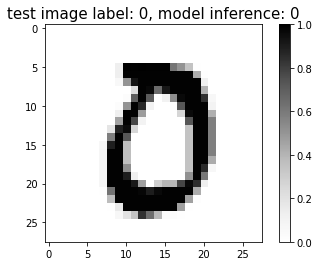

In [6]:
# Visualize image and model inference
images, labels = next(iter(test_loader))

ridx = torch.randint(0, batch_size, (1,)) # 0~50 인덱스 중 하나를 선택해 출력해보겠습니다.

image = images[ridx[0].data]
label = labels[ridx[0].data]

output = model(image.unsqueeze(0).to(device))
_, predicted = torch.max(output.data, 1)

plt.title('test image label: {}, model inference: {}'.format(label.data, predicted[0].data), fontsize=15)
plt.imshow(image.view(28, 28), cmap=plt.cm.Greys)
plt.colorbar()
plt.show()


### Advanced Architecture

이외에도 좋은 성능을 내는 모델들은 다음과 같은 방법들을 사용합니다.

#### 1x1 Convolution layer (convolution with kernel_size = 1)

![https://cheong.netlify.app/static/fb817ed940cd331991e5f40effdaf455/799d3/image16.png](https://cheong.netlify.app/static/fb817ed940cd331991e5f40effdaf455/799d3/image16.png)

일반적으로 input의 channels을 줄여 연산량을 줄이거나, 다른 features의 channels와 개수를 일치시키고 싶을때 사용됩니다. <br/>
예를 들어 3x3 conv, 5x5 conv와 같이 연산량이 큰 컨볼루션을 적용하기 전에 1x1 conv로 입력 차원을 줄인뒤 3x3 conv를 적용하면 더 적은 비용으로 비슷한 효과를 볼 수 있습니다. (ResNet의 Bottleneck block) <br/>



In [7]:
inp = torch.ones((1, 10, 4, 4)) # C=10

conv1x1 = nn.Conv2d(in_channels=10, out_channels=3, kernel_size=1, stride=1, padding=0) # kernel_size = 1

out = conv1x1(inp)

print(inp.shape)
print(out.shape) # C=3

torch.Size([1, 10, 4, 4])
torch.Size([1, 3, 4, 4])


#### Element-wise addition / Concatenate

|![](https://codeforwin.org/ezoimgfmt/secureservercdn.net/160.153.138.219/b79.d22.myftpupload.com/wp-content/uploads/2015/07/matrix-addition.png?ezimgfmt=rs:392x204/rscb1)|
|:--:|
|Element-wise Addition|

|![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile4.uf.tistory.com%2Fimage%2F99D452405B49B4DA10949D)|
|:--:|
|Concatenate|

element-wise addition은 말 그대로 동일한 차원을 가진 tensor의 요소끼리 더하는 연산을 의미합니다. <br/>
concatenate은 선택한 차원을 기준으로 tensors를 연결하는 것을 의미합니다.

In [8]:
A = torch.arange(1, 10).view(3, 3)
B = torch.arange(9, 0, -1).view(3, 3)

print(A)
print(B)

out1 = A + B # element-wise addition
print(out1)

out2 = torch.cat((A, B), 0) # concat in 0 dim
print(out2)
print(out2.shape)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
tensor([[9, 8, 7],
        [6, 5, 4],
        [3, 2, 1]])
tensor([[10, 10, 10],
        [10, 10, 10],
        [10, 10, 10]])
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9],
        [9, 8, 7],
        [6, 5, 4],
        [3, 2, 1]])
torch.Size([6, 3])


#### Skip connection (shortcut connection)

|![](https://datascienceschool.net/upfiles/6182312059774a81a2a26246bd4e83f2.png)|
|:---:|
|*Skip Connection (ResNet)*|

|![](https://cheong.netlify.app/static/5a711b3b3b3d4789e4d0e0fc742c0e11/7f576/image24.png)|
|:---:|
|*Bottleneck Block (ResNet)*|
<br/>

skip connection은 ResNet에서 제안되어졌으며 몇가지 장점들로 인해 많은 CNNs에서 필수적인 요소로 사용하고 있습니다. <br/>

- 깊은 모델의 Degradation 현상 해소
- 원활한 gradient 전파


In [9]:
x_in = torch.ones((1, 256, 28, 28))

conv1 = nn.Conv2d(256, 64, kernel_size=1, stride=1, padding=0) # 1x1 conv
conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1) # 3x3 conv with padding
conv3 = nn.Conv2d(64, 256, kernel_size=1, stride=1, padding=0) # 1x1 conv
F = nn.Sequential(conv1, conv2, conv3) # Bottleneck block

F_out = F(x_in)

print(F_out.shape)

x_out = F_out + x_in # skip connection (element-wise addition)
print(x_out.shape)

torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
